 # Binary Classification Task for Fall Detection with MobiAct Dataset

**MobiAct Paper (1st Release):** https://www.researchgate.net/publication/302973506_The_MobiAct_Dataset_Recognition_of_Activities_of_Daily_Living_using_Smartphones

**MobiAct Paper (2nd Release):** https://www.researchgate.net/publication/318548841_Human_Daily_Activity_and_Fall_Recognition_Using_a_Smartphone's_Acceleration_Sensor

**Methodologies:**

- Anomaly Detection: Falls can be categorized as abnormal and sudden activities of a persons physical activity routine.

- Threshold based approaches.

- Machine Learning techniques (outperforms recognition accuracy).

# 1. Import Packages

In [44]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas to display all columns
pd.set_option('display.max_columns', None)

In [3]:
import os
print(os.getcwd())  # This shows where your script is running from

C:\Users\Usuario\Documents\Repos\ilab-group-12-1-fall-detection\notebooks


# 2. Load Dataset

In [4]:
# Load datasets
df_50ms = pd.read_pickle("../data/raw/df_resample_50ms.pkl")
df_100ms = pd.read_pickle("../data/raw/df_resample_100ms.pkl")
df_200ms = pd.read_pickle("../data/raw/df_resample_200ms.pkl")

The data is already resampled (at 50ms, 100ms, 200ms) to ensure uniform time intervals between sensor readings, making our time series data consistent.

# 3. Initial Dataset Exploration

**MobiAct Dataset**

* Records of accelerometer, gyroscope, orientation sensors of a smartphone.
* 66 subjects.
* 12 different types of ADLs.
* 4 different types of falls.
* 1 scenario of daily living.
* More than 3200 trials.

In [5]:
df_50ms.head()

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,label,subject_id,trial,age,height,weight,gender
timestamp,,,,,,,,,,,,,
1970-01-01 00:00:58.100,-0.450704,9.777446,0.893127,-0.016901,-0.023247,-0.003631,STD,64.0,1.0,26.0,181.0,70.0,M
1970-01-01 00:00:58.150,-0.446619,9.821682,0.833732,-0.016829,-0.009896,-0.000183,STD,64.0,1.0,26.0,181.0,70.0,M
1970-01-01 00:00:58.200,-0.406528,9.806871,0.807646,-0.014294,-0.019548,-0.004459,STD,64.0,1.0,26.0,181.0,70.0,M
1970-01-01 00:00:58.250,-0.439627,9.887962,1.013191,-0.045632,0.042791,0.016280,STD,64.0,1.0,26.0,181.0,70.0,M
1970-01-01 00:00:58.300,-0.455615,9.793036,1.098758,-0.094470,0.156717,0.018204,STD,64.0,1.0,26.0,181.0,70.0,M


In [8]:
df_50ms.columns.to_list()

['acc_x',
 'acc_y',
 'acc_z',
 'gyro_x',
 'gyro_y',
 'gyro_z',
 'label',
 'subject_id',
 'trial',
 'age',
 'height',
 'weight',
 'gender']

In [6]:
df_50ms['label'].value_counts(dropna=False)

label
WAL    158710
STD    157895
SIT     45046
JOG     38975
JUM     32612
LYI     28675
STU     22531
STN     21767
CSO     11378
CSI     10585
SCH      5304
BSC      2892
FKL      2508
SDL      2371
FOL      2086
CHU      1660
Name: count, dtype: int64

## Data Dictionary

* **WAL:** Walking
* **STD:** Standing
* **SIT:** Sitting on chair
* **JOG:** Jogging
* **JUM:** Jumping
* **LYI:** Lying
* **STU:** Stairs up
* **STN:** Stairs down
* **CSO:** Car step out
* **CSI:** Car step in
* **SCH:** Stand to sit (sit on chair)
* <u>**BSC:** Back-sitting-chair</u>. Fall backward while trying to sit on a chair.
* <u>**FKL:** Front-knees-lying</u>. Fall forward from standing, first impact on knees.
* <u>**SDL:** Sideward-lying</u>. Fall sideward from standing, bending legs.
* <u>**FOL:** Forward-lying</u>. Fall forward from standing, use of hands to dampen fall.
* **CHU:** Sit to stand (chair up)

# 4. Preprocessing for Modelling

We need to distinguish between **fall events** and **non-fall (ADL – Activities of Daily Living) events**.

**[4.1] Binary Labeling:**

Transform the label column into a binary class.

1 = Fall

0 = Not Fall (any ADL)

In [10]:
def label_falls(df):
    fall_labels = ['BSC', 'FKL', 'SDL', 'FOL']
    df = df.copy()
    df['binary_label'] = df['label'].apply(lambda x: 1 if x in fall_labels else 0)
    return df

**[4.2] Feature Extraction:**

MobiAct is time-series based.
Since ML Classifiers can't directly consume raw time series data (sequence of sensor readings over time), we need to segment the data using sliding windows and extract features from each window.

X = np.array(features) — the features.

y = np.array(labels) — the binary labels.

As these are the baseline models is okay. We will use deep learning models that can learn from sequences (e.g. RNNs, CNNs, Transformers) later.

1. Segment the time series (e.g. with a sliding window of 2.5 seconds).
2. Summarise each segment with features like: mean, std, min, max.
3. Each segment becomes one row in the feature matrix — suitable for supervised learning.

In [11]:
def extract_features_from_windows(df, window_duration_s=2.5, overlap=0.5, sampling_rate_ms=50):
    """
    Slide window through each trial of each subject.
    Extract statistical features per window: mean, std, min, max.
    """
    window_size = int(window_duration_s * 1000 / sampling_rate_ms)
    step_size = int(window_size * (1 - overlap))
    
    features = []
    labels = []
    
    for subject in df['subject_id'].unique():
        subject_data = df[df['subject_id'] == subject]
        
        for trial in subject_data['trial'].unique():
            trial_data = subject_data[subject_data['trial'] == trial]
            trial_data = trial_data.sort_index()  # sort by timestamp

            signal_data = trial_data[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']].values
            binary_labels = trial_data['binary_label'].values

            for start in range(0, len(signal_data) - window_size + 1, step_size):
                window = signal_data[start:start + window_size]
                window_labels = binary_labels[start:start + window_size]
                label = int(np.any(window_labels))  # 1 if fall happened in the window
                
                # statistical features
                feat = np.concatenate([
                    window.mean(axis=0),
                    window.std(axis=0),
                    window.min(axis=0),
                    window.max(axis=0),
                ])
                
                features.append(feat)
                labels.append(label)
    
    return np.array(features), np.array(labels)

**[4.3] Train/Test Split:**

Stratified Random Train-Test Split

In [12]:
def split_data(X, y, test_size=0.2, random_state=42):
    """
    Perform stratified train-test split to preserve fall/non-fall proportion.
    """
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

# 5. Train Model

In [29]:
def train_model(X_train, y_train, model_type="random_forest", **kwargs):
    """
    Train a classifier. Supported types: 'random_forest', 'logistic', 'svm', 'mlp'
    """
    if model_type == "random_forest":
        model = RandomForestClassifier(n_estimators=100, random_state=42, **kwargs)
    elif model_type == "logistic":
        model = LogisticRegression(max_iter=1000, random_state=42, **kwargs)
    elif model_type == "svm":
        model = SVC(probability=True, random_state=42, **kwargs)
    elif model_type == "mlp":
        model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42, **kwargs)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    model.fit(X_train, y_train)
    return model

# 6. Evaluate Model

Key metrics:

* Accuracy

* Precision, Recall, F1-score

* Confusion Matrix

* ROC AUC

Focus on recall for falls (class 1) — since missing a fall is riskier than a false positive.

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def evaluate_model(model, X_test, y_test, model_name=None, show_confusion_matrix=True):
    """
    Evaluate the model and print standard classification metrics.
    """
    if model_name:
        print(f"\n📈 Evaluation Results for Model: {model_name}")

    y_pred = model.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    if show_confusion_matrix:
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"\nROC AUC: {roc_auc:.4f}")
    except AttributeError:
        print("\nROC AUC not available (predict_proba missing for this model).")

# 7. Run Pipeline

In [35]:
def run_pipeline(df, sampling_rate_ms, window_duration_s=2.5, overlap=0.5, model_type="random_forest"):
    print(f"\n📊 Running pipeline for sampling rate = {sampling_rate_ms} ms | Model = {model_type}")

    df = label_falls(df)

    X, y = extract_features_from_windows(
        df,
        window_duration_s=window_duration_s,
        overlap=overlap,
        sampling_rate_ms=sampling_rate_ms
    )

    print(f"\nTotal windows: {len(y)} | Fall: {np.sum(y)} | Non-Fall: {len(y) - np.sum(y)}")

    X_train, X_test, y_train, y_test = split_data(X, y)

    model = train_model(X_train, y_train, model_type=model_type)

    evaluate_model(model, X_test, y_test, model_name=model_type)

    return model

**[7.1] Run pipeline for `df_50ms`**

In [36]:
for model_type in ["random_forest", "logistic", "svm", "mlp"]:
    run_pipeline(df_50ms, sampling_rate_ms=50, model_type=model_type)


📊 Running pipeline for sampling rate = 50 ms | Model = random_forest

Total windows: 21282 | Fall: 879 | Non-Fall: 20403

📈 Evaluation Results for Model: random_forest

Classification Report:
              precision    recall  f1-score   support

           0     0.9696    0.9995    0.9843      4081
           1     0.9600    0.2727    0.4248       176

    accuracy                         0.9695      4257
   macro avg     0.9648    0.6361    0.7045      4257
weighted avg     0.9692    0.9695    0.9612      4257


Confusion Matrix:
[[4079    2]
 [ 128   48]]

ROC AUC: 0.9224

📊 Running pipeline for sampling rate = 50 ms | Model = logistic

Total windows: 21282 | Fall: 879 | Non-Fall: 20403

📈 Evaluation Results for Model: logistic

Classification Report:
              precision    recall  f1-score   support

           0     0.9683    0.9961    0.9820      4081
           1     0.7288    0.2443    0.3660       176

    accuracy                         0.9650      4257
   macro avg    

**Best Performer for Fall Detection @50ms:**

**MLP (Multilayer Perceptron)** has the best F1-score (0.5243) and recall (0.3977) for fall detection.

**[7.2] Run pipeline for `df_100ms`**

In [38]:
for model_type in ["random_forest", "logistic", "svm", "mlp"]:
    run_pipeline(df_100ms, sampling_rate_ms=100, model_type=model_type)


📊 Running pipeline for sampling rate = 100 ms | Model = random_forest

Total windows: 69983 | Fall: 3158 | Non-Fall: 66825

📈 Evaluation Results for Model: random_forest

Classification Report:
              precision    recall  f1-score   support

           0     0.9810    0.9990    0.9900     13365
           1     0.9664    0.5918    0.7341       632

    accuracy                         0.9806     13997
   macro avg     0.9737    0.7954    0.8620     13997
weighted avg     0.9804    0.9806    0.9784     13997


Confusion Matrix:
[[13352    13]
 [  258   374]]

ROC AUC: 0.9844

📊 Running pipeline for sampling rate = 100 ms | Model = logistic

Total windows: 69983 | Fall: 3158 | Non-Fall: 66825

📈 Evaluation Results for Model: logistic

Classification Report:
              precision    recall  f1-score   support

           0     0.9722    0.9938    0.9829     13365
           1     0.7522    0.3987    0.5212       632

    accuracy                         0.9669     13997
   macro

**Best Performer for Fall Detection @100ms:**

**MLP** again has the highest recall (0.7405), F1-score (0.7946), and a near-top ROC AUC, making it the most reliable model for detecting falls.

Compared to 50ms, all models generally improved at 100ms, especially in recall and F1-score.

**[7.3] Run pipeline for `df_200ms`**

In [40]:
for model_type in ["random_forest", "logistic", "svm", "mlp"]:
    run_pipeline(df_200ms, sampling_rate_ms=200, model_type=model_type)


📊 Running pipeline for sampling rate = 200 ms | Model = random_forest

Total windows: 70855 | Fall: 3200 | Non-Fall: 67655

📈 Evaluation Results for Model: random_forest

Classification Report:
              precision    recall  f1-score   support

           0     0.9788    0.9976    0.9881     13531
           1     0.9158    0.5437    0.6824       640

    accuracy                         0.9771     14171
   macro avg     0.9473    0.7707    0.8352     14171
weighted avg     0.9760    0.9771    0.9743     14171


Confusion Matrix:
[[13499    32]
 [  292   348]]

ROC AUC: 0.9804

📊 Running pipeline for sampling rate = 200 ms | Model = logistic

Total windows: 70855 | Fall: 3200 | Non-Fall: 67655

📈 Evaluation Results for Model: logistic

Classification Report:
              precision    recall  f1-score   support

           0     0.9680    0.9945    0.9811     13531
           1     0.7249    0.3047    0.4290       640

    accuracy                         0.9634     14171
   macro

**Best Performer for Fall Detection @200ms:**

**MLP** again has the highest recall (0.6297), F1-score (0.7114).

Compared to 100ms, the models performance is lower.

# 8. Results Summary

| Sampling Rate | Model         | Accuracy | Recall (Fall) | F1-Score (Fall) | ROC AUC |
|---------------|---------------|----------|----------------|------------------|---------|
| 50ms          | Random Forest | 0.9695   | 0.2727         | 0.4248           | 0.9224  |
| 50ms          | Logistic      | 0.9650   | 0.2443         | 0.3660           | 0.8648  |
| 50ms          | SVM           | 0.9657   | 0.1818         | 0.3048           | 0.8249  |
| 50ms          | MLP           | 0.9702   | 0.3977         | 0.5243           | 0.9191  |
| 100ms         | Random Forest | 0.9806   | 0.5918         | 0.7341           | 0.9844  |
| 100ms         | Logistic      | 0.9669   | 0.3987         | 0.5212           | 0.9395  |
| 100ms         | SVM           | 0.9742   | 0.4399         | 0.6063           | 0.9209  |
| 100ms         | **MLP**       | **0.9827** | **0.7405**     | **0.7946**       | **0.9830**  |
| 200ms         | Random Forest | 0.9771   | 0.5437         | 0.6824           | 0.9804  |
| 200ms         | Logistic      | 0.9634   | 0.3047         | 0.4290           | 0.9227  |
| 200ms         | SVM           | 0.9699   | 0.3656         | 0.5235           | 0.9117  |
| 200ms         | MLP           | 0.9769   | 0.6297         | 0.7114           | 0.9815  |


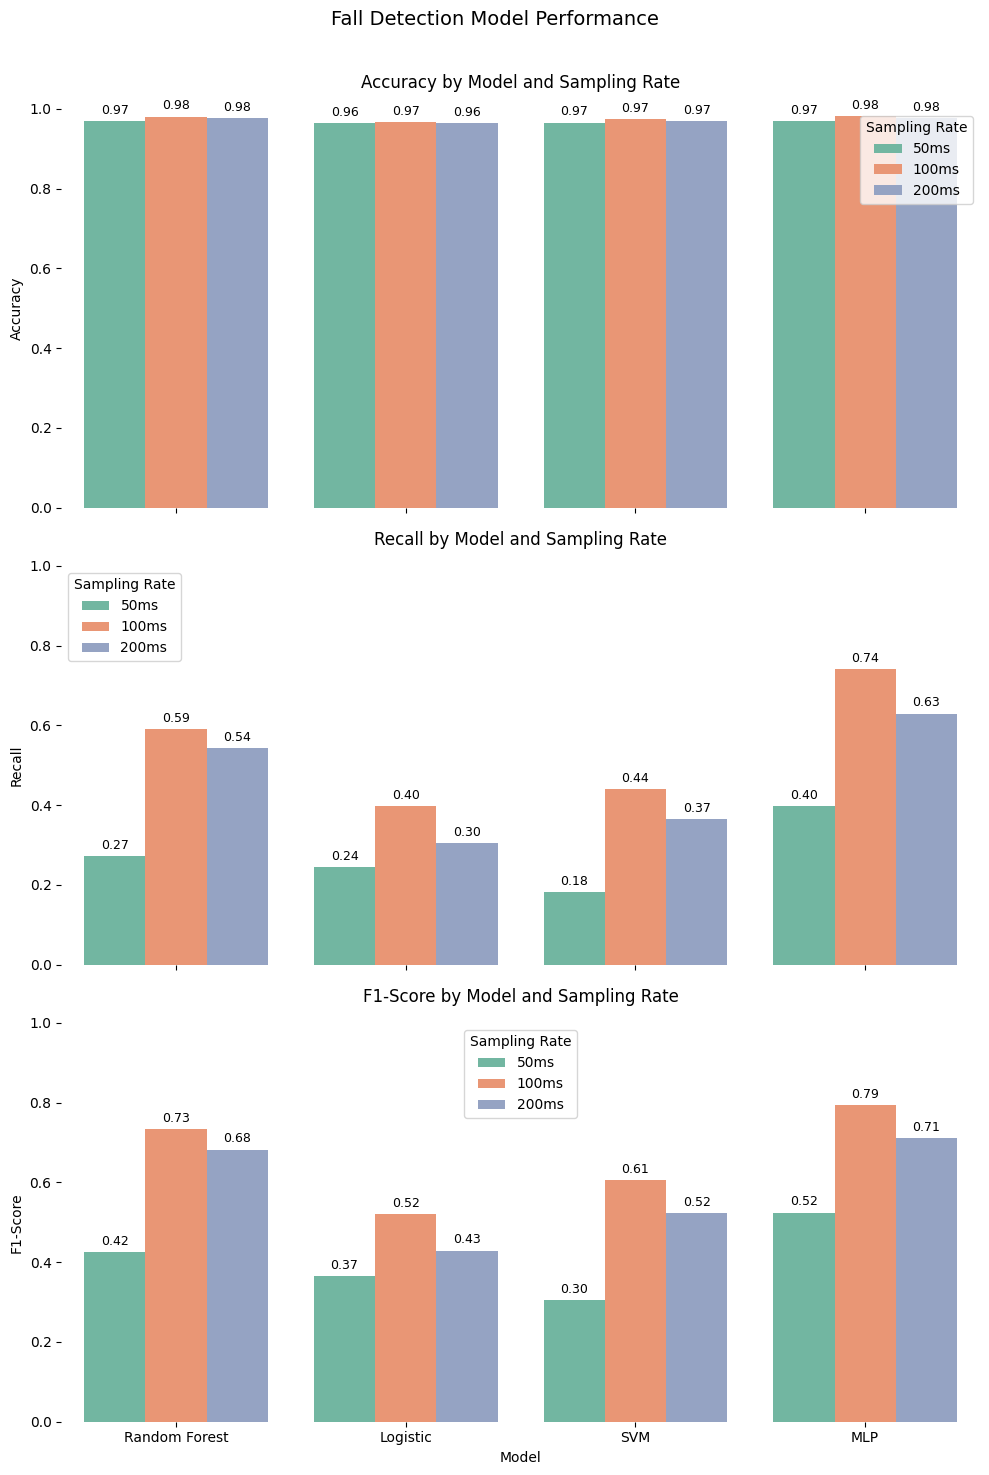

In [60]:
# Data
data = [
    ("50ms", "Random Forest", 0.9695, 0.2727, 0.4248, 0.9224),
    ("50ms", "Logistic", 0.9650, 0.2443, 0.3660, 0.8648),
    ("50ms", "SVM", 0.9657, 0.1818, 0.3048, 0.8249),
    ("50ms", "MLP", 0.9702, 0.3977, 0.5243, 0.9191),
    ("100ms", "Random Forest", 0.9806, 0.5918, 0.7341, 0.9844),
    ("100ms", "Logistic", 0.9669, 0.3987, 0.5212, 0.9395),
    ("100ms", "SVM", 0.9742, 0.4399, 0.6063, 0.9209),
    ("100ms", "MLP", 0.9827, 0.7405, 0.7946, 0.9830),
    ("200ms", "Random Forest", 0.9771, 0.5437, 0.6824, 0.9804),
    ("200ms", "Logistic", 0.9634, 0.3047, 0.4290, 0.9227),
    ("200ms", "SVM", 0.9699, 0.3656, 0.5235, 0.9117),
    ("200ms", "MLP", 0.9769, 0.6297, 0.7114, 0.9815),
]

df = pd.DataFrame(data, columns=["Sampling Rate", "Model", "Accuracy", "Recall", "F1-Score", "ROC AUC"])
metrics = ["Accuracy", "Recall", "F1-Score"]

# Plot each metric in a separate subplot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15), sharex=True)

for ax, metric in zip(axes, metrics):
    sns.barplot(data=df, x="Model", y=metric, hue="Sampling Rate", palette="Set2", errorbar=None, ax=ax)
    ax.set_title(f"{metric} by Model and Sampling Rate", fontsize=12, pad=15)  # <- spacing added here
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='', alpha=0.7)

    # Add labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", padding=3, fontsize=9)

# Turn off plot borders (spines)
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)

axes[-1].set_xlabel("Model")
plt.suptitle("Fall Detection Model Performance", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

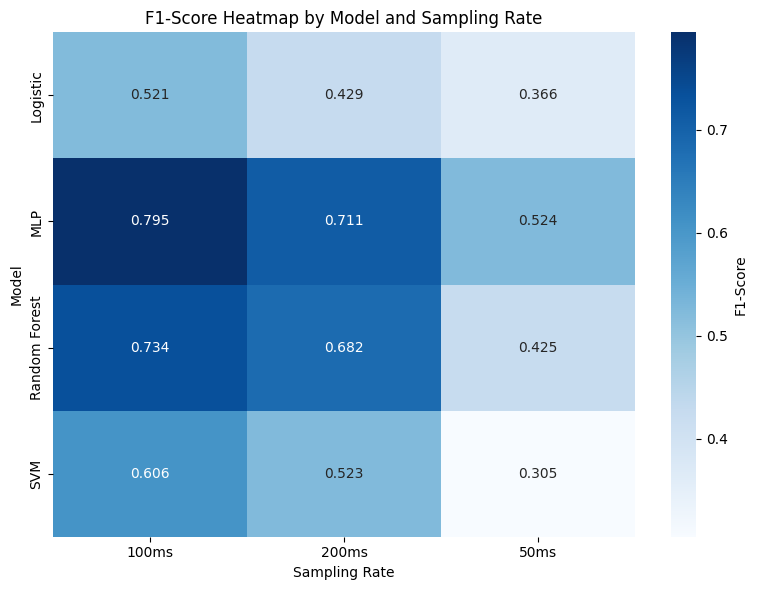

In [51]:
# Pivot for heatmap
heatmap_data = df.pivot(index="Model", columns="Sampling Rate", values="F1-Score")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="Blues", cbar_kws={'label': 'F1-Score'})
plt.title("F1-Score Heatmap by Model and Sampling Rate")
plt.ylabel("Model")
plt.xlabel("Sampling Rate")
plt.tight_layout()
plt.show()

**Best Model for Fall Detection**
Based on the highest recall and F1-score for detecting falls, the top performer is:

**MLP at 100ms**

* Accuracy = 0.9827 The proportion of total predictions that were correct.

* Recall = 0.7405 The proportion of actual falls that were correctly detected.

* F1-score = 0.7946 Harmonic mean of precision and recall.

* ROC AUC = 0.9830 How well the model separates falls from non-falls across all thresholds.